# Homework #7:
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 10/12/2019|
|Updated | 10/12/2019|

## 11.5 Monte Carlo

### 1. "Integrate"
First, let's generate some curves and a region for which we would like to calculate the area.

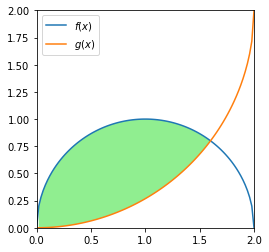

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    return np.sqrt(1-(x-1)**2)
def g(x):
    return 2-np.sqrt(4-x**2)

x1 = np.linspace(0,2,100)
y1 = f(x1)
y2 = g(x1)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.plot(x1, y1, label="$f(x)$")
ax1.plot(x1, y2, label="$g(x)$")
ax1.legend(loc="upper left")
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
ax1.fill_between(x1, y1, y2, where=y1>y2, facecolor='lightgreen')
plt.show()

To calculate the area shaded in green using _Monte Carlo Integration_ we will:
- Generate a large number of $N$ random points in the bounded square.
- Count the number of points $k$ that fall inside the shaded region .
- If the probability is $P = k/N \approx I/A$, then $I \approx kA/N$

In [2]:
# Monte Carlo intergral
from random import random

def MC(N, f, g, x_start, x_end, y_start, y_end):
    """
    Calculate and return the area between two functions, f(x) and 
    g(x), using the Monte Carlo method, by generating N random points
    in the bounded rectange defined by a width (x_start and x_end)
    and a height (y_start, y_end)
    """
    width = x_end - x_start
    height = y_end - y_start
    count = 0
    
    for i in range(N):
        x = width*random() + x_start
        y = height*random() + y_start
        if y < f(x) and y > g(x):
            count += 1
    I = width*height*count/N
    
    return I

In [3]:
import time

timer_start = time.perf_counter() # start of timer
area = MC(int(1e7), f, g, 0, 2, 0, 2)
timer_end = time.perf_counter() # end timer
time = timer_end - timer_start

print("The area shaded in green is", area)
print("Time to calculate:", time, "seconds")

The area shaded in green is 0.9614544
Time to calculate: 17.417688499997894 seconds


### 2. Error Analysis
Let's now calculate the area many times (e.g., 100) for different values of $N$ (e.g., 100, 1000, 10,000, 100,000), collect the data and determine their variances.

In [4]:
def MCstats(N, f, g, x_start, x_end, y_start, y_end, runs, plot):
    """
    Repeatedly calculate an area using the Monte Carlo method, MC(),
    for as many "runs," compile the dataset and return its variance.
    """
    
    data = np.zeros(runs)
    
    for i in range(runs):
        data[i] = MC(N, f, g, x_start, x_end, y_start, y_end)
        
    title = "Statistics for " + str(runs) + " runs with $N =$" + str(N)
    
    if plot:
        plt.figure()
        plt.plot(data, ".")
        plt.title(title)
        plt.xlabel("Run No.")
        plt.ylabel("Calc'd Area")
        plt.ylim(0.5,1.5)
        plt.show()
    
    return np.var(data)

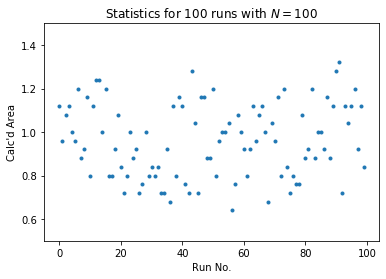

Variance: 0.028044


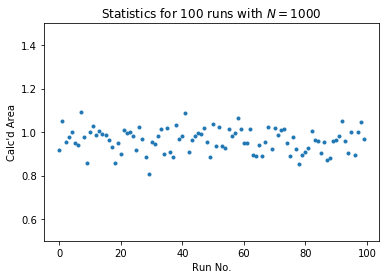

Variance: 0.0029860144000000005


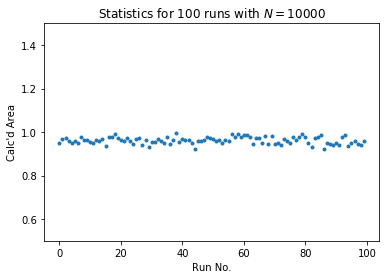

Variance: 0.0002568003840000002


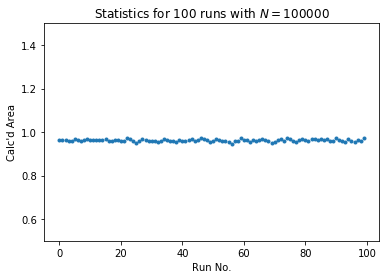

Variance: 2.5825285759999957e-05


In [5]:
runs = 100
diff_Ns = [100, 1000, 10000, 100000]

for i in diff_Ns:
    print("Variance:", MCstats(i, f, g, 0, 2, 0, 2, runs, True))

As we expect, the variance of the calculated area over multiple runs decreases as $N$ increases, corresponding to an improvement in accuracy.

## 12.4 Importance Sampling

### 1. Example
Using the importance sampling method, with $w(x) = x^{-1/2}$ and one million random points, let's calculate a value for the integral

$$ I = \int_0 ^1 \frac{x^{-1/2}}{e^x + 1} dx \tag{1}$$

First let's plot the integrand $f(x)$ and weighting function $w(x)$.

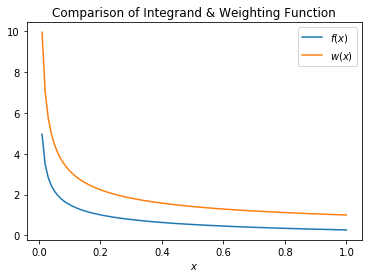

In [13]:
f = lambda x: 1/np.sqrt(x)/(np.exp(x)+1)
w = lambda x: 1/np.sqrt(x)

x = np.linspace(0,1,100)
plt.plot(x[1:], f(x[1:]), label='$f(x)$') # start w/ 2nd element 
plt.plot(x[1:], w(x[1:]), label='$w(x)$') # to avoid div. by 0
plt.title("Comparison of Integrand & Weighting Function")
plt.xlabel("$x$")
plt.legend()
plt.show()

Next, let's determine the probability function, defined as

$$
\begin{equation*}
    p(x) \equiv \frac{w(x)}{\int_a^b w(x)dx}.
    \tag{2}
\end{equation*}
$$

With $w(x) = x^{-1/2}$, evaluating the integral in the denominator, on the interval from $a=0$ to $b=1$, yields

$$
\begin{align}
    \int_a^b w(x)dx =& \int_0^1 x^{-1/2}dx \\
                =& 2x^{1/2} \big|_0^1 \\
                =& 2.
    \tag{3}
\end{align}
$$

Plugging Eq. 3 into 2 yields

$$
\begin{align}
    p(x) =& \frac{x^{-1/2}}{2}. \\
    \tag{4}
\end{align}
$$

Now, the cumulative distribution function $F(x)$ of the probability function $p(x)$ becomes

$$
\begin{align}
    F(x) \equiv& \int_0^x p(x)dx \\
              =& \int_0^x \frac{x^{-1/2}}{2} \\
              =& x^{1/2}\big|_0^x \\
              =& x^{1/2}.
    \tag{5}
\end{align}
$$

and its inverse,

$$
\begin{align}
     F^{-1}(x) =& x^2.        
    \tag{6}
\end{align}
$$

We finally can calculate the integral in Eq. 1 using the formula

$$ I \approx  \frac{1}{N} \sum_{i=1}^{N} \frac{f(x_i)}{w(x_i)} \int_a^b w(x)dx \tag{7}$$

by averaging $f(x)/w(x)$ in the points generated from $F^{-1}(x)$.

In [14]:
from scipy.integrate import quad

def IMC(f, w, F_inv, x_start, x_end, N):
    """
    Calculate and return the integral of 'f', on the interval
    'x_start' and 'x_end', using the Monte Carlo method with
    importance sampling, with weighting function 'w', inverse
    transform sampling function 'F_inv', and 'N' random points.
    """
    const = quad(w, x_start, x_end)[0]
    width = x_end - x_start
    I = 0
    
    for i in range(N):
        x = width*random() + x_start
        y = F_inv(x)
        I += f(y)/w(y)
        
    return I/N*const

In [15]:
F_inv = lambda x: x**2 # def inv transform sampling

print("I[0, 1] ≈", IMC(f, w, F_inv, 0, 1, int(1e6)))

I[0, 1] ≈ 0.8390644788925933


For comparison, we can calculate the integral using SciPy.

In [17]:
print("From SciPy: I =", quad(f, 0, 1)[0])

From SciPy: I = 0.8389329600133838


### 2. Example
Using importance sampling, with $w(x) = 1/x$ and one million random points, let's calculate a value for the integral

$$ I = \int_0 ^1 \frac{x^{-1}}{e^x + 1} dx \tag{8} $$

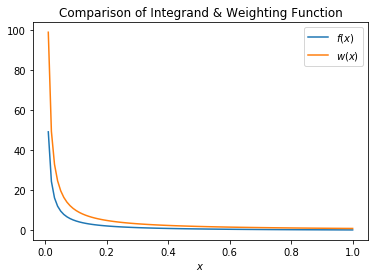

In [19]:
f = lambda x: 1/x/(np.exp(x)+1)
w = lambda x: 1/x

x = np.linspace(0,1,100)
plt.plot(x[1:], f(x[1:]), label='$f(x)$') # start w/ 2nd element 
plt.plot(x[1:], w(x[1:]), label='$w(x)$') # to avoid div. by 0
plt.title("Comparison of Integrand & Weighting Function")
plt.xlabel("$x$")
plt.legend()
plt.show()

Again, from Eq. 2,

$$
\begin{equation*}
    p(x) \equiv \frac{w(x)}{\int_a^b w(x)dx}.
\end{equation*}
$$

But this time, since $w(x) = x^{-1}$, the integral in the denominator is divergent:

$$
\begin{align}
    \int_a^b w(x)dx =& \int_0^1 x^{-1}dx \\
                =& \ln x \big|_0^1 \textrm{ (undefined)}.
    \tag{9}
\end{align}
$$

We can try approximating its value by using SciPy, using an initial bound very slightly above zero.

In [52]:
a = quad(w, 5.981e-16, 1)[0] # 5.981e-16 is the smallest value
                             # allowed by quad() for w
a

35.052773709842654

Thus, we'll take

$$
\begin{align}
    a = \int_0^1 w(x)dx \approx 35.052773709842654.
    \tag{10}
\end{align}
$$

Plugging Eq. 10 into 2 yields

$$
\begin{align}
    p(x) =& \frac{x^{-1}}{a}, \\
    \tag{11}
\end{align}
$$

but,

$$
\begin{align}
    F(x) \equiv& \int_0^x p(x)dx \\
              =& \frac{1}{a}\int_0^x \frac{x^{-1}} \\
              =& x^{1/2}\big|_0^x \\
              =& x^{1/2},
    \tag{5}
\end{align}
$$

is again divergent.

$$
\begin{align}
     F^{-1}(x) =& x^2.        
    \tag{6}
\end{align}
$$